In [1]:
# using tf 2.0
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
import tqdm 
import itertools
from sklearn.model_selection import train_test_split
# Import hand craft scripts
import def_model
import data_gen

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth( device=gpu, enable=True)

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train,x_val,y_train,y_val=train_test_split(x_train, y_train, test_size=len(y_train)//10*2)

In [3]:
way =10
max_epoch = 40
BATCH_SIZE=128
gen_train=data_gen.DataGenerator(x_train,y_train,way,batch_size=BATCH_SIZE,shuffle=True)
gen_val=data_gen.DataGenerator(x_val,y_val,way,batch_size=BATCH_SIZE,shuffle=False)
len(gen_train), len(gen_val)

(375, 93)

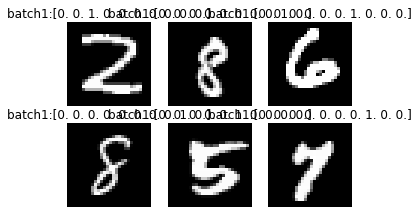

In [4]:
for batch_data,batch_label in gen_train:
    break
gp,ee,n_row,n_col=1,1,2,3
plt.figure(figsize=(n_col*1.7,n_row*1.7))
for ii in range(n_row):
    for jj in range(n_col):
        plt.subplot(n_row,n_col,ee);plt.axis('off');plt.title(f"batch{gp}:{batch_label[ee]}")
        plt.imshow(batch_data[ee,...,0],"gray")
        ee+=1
plt.show()

In [5]:
N_FILTER=32
CHS=32
cnn=def_model.cnn_model(way,N_FILTER)
lstm=def_model.LSTM_model(CHS)


cnn_loss_fn=keras.losses.categorical_crossentropy
# lstm_loss_fn=keras.losses.mae
acc_fn = keras.metrics.categorical_accuracy

## There are 11k parameters to update

layer idx: w:(3, 3, 1, 32) + b: (32,) = 320
layer idx: w:(1, 1, 32, 16) + b: (16,) = 528
layer idx: w:(3, 3, 16, 32) + b: (32,) = 4640
layer idx: w:(1, 1, 32, 16) + b: (16,) = 528
layer idx: w:(3, 3, 16, 32) + b: (32,) = 4640
layer idx: w:(1, 1, 32, 16) + b: (16,) = 528
layer idx: w:(16, 10) + b: (10,) = 170
totla 11354 parameters


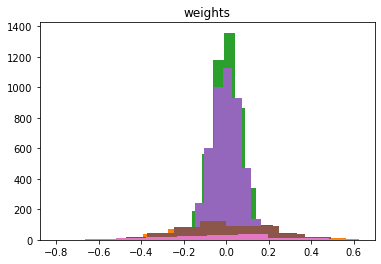

In [6]:
cnn.print_shape()
for ii in [cnn.cnn1,cnn.cnn1_1,cnn.cnn2,cnn.cnn2_1,cnn.cnn3,cnn.cnn3_1,cnn.dense]:
    plt.hist(np.reshape(ii.w.numpy(),-1))
plt.title("weights")
plt.show()

In [7]:
def flat_tensors(mdl):
    tensors=tf.concat([tf.reshape(ww,[-1]) for ww in mdl],axis=0)
    return tf.reshape(tensors,(len(tensors),1,1))
lr=0.01

cnn_param_num=sum([np.prod(ww.shape) for ww in cnn.trainable_weights()])
opt_rnn=keras.optimizers.Adam(lr=lr)
cnn_loss_fn=keras.losses.categorical_crossentropy
acc_fn = keras.metrics.categorical_accuracy

In [8]:
best_loss=np.Inf
flt_grads=flat_tensors(cnn.trainable_weights()).numpy().copy()
h=[[tf.ones((cnn_param_num,CHS)),tf.ones((cnn_param_num,CHS))],[tf.ones((cnn_param_num,CHS)),tf.ones((cnn_param_num,CHS))]]

In [9]:
new_update,new_state=lstm.forward(flt_grads,state=h)

In [10]:
flt_grads=tf.Variable(flat_tensors(cnn.trainable_weights()))
h=[[tf.ones((cnn_param_num,CHS)),tf.ones((cnn_param_num,CHS))],[tf.ones((cnn_param_num,CHS)),tf.ones((cnn_param_num,CHS))]]

# init=True
best_loss=np.Inf
for epoch in range(max_epoch):
    train_sess=tqdm.tqdm(gen_train)
#     train_sess=tqdm.notebook.tqdm(gen_train)
    train_acc=[]    
    for data,label_1_hot in train_sess:
#         if init:
#             init=False
#             logits=cnn(data)
#             loss1=cnn_loss_fn(label_1_hot, logits)
        
        with tf.GradientTape(persistent=True) as tape:
            new_update,new_state=lstm.forward(flt_grads,state=h)
            new_update=tf.expand_dims(new_update,-1)
            
            cnn.assign_update(new_update*0.01)
            logits=cnn(data)
            loss1=cnn_loss_fn(tf.Variable(label_1_hot), logits)+tf.sqrt(tf.reduce_mean(new_update**2))*0.1
        grads_cnn=tape.gradient(loss1,cnn.trainable_weights())
    
        grads=tape.gradient(new_update,lstm.trainable_weights,output_gradients=-flat_tensors(grads_cnn))
    
        h=new_state
        
        flt_grads=flat_tensors(grads_cnn)
        
        opt_rnn.apply_gradients(zip(grads, lstm.trainable_weights))
        acc=acc_fn(label_1_hot,logits).numpy().mean()
        train_acc.append(acc)
        train_sess.set_postfix({"CNN loss": loss1.numpy().mean(),"acc":np.mean(train_acc)})

    val_acc=[]
    val_loss=[]
    for data,label_1_hot in gen_val:
#         label_1_hot = tf.one_hot(tf.cast(label, tf.int32),depth=way)
        logits=cnn(data)
        loss1=cnn_loss_fn(label_1_hot, logits).numpy()
        acc=acc_fn(label_1_hot,logits).numpy().mean()
        val_loss.append(loss1)
        val_acc.append(acc)
    print(f"CNN val: loss: {np.mean(val_loss):.08f},acc: {np.mean(val_acc):.02f},lr: {lr}")
    if best_loss<np.mean(val_loss):
        break
    else:
        best_loss=np.mean(val_loss)
#     lr=lr*0.1
#     opt_cnn=keras.optimizers.Adam(lr=lr)



  1%|          | 2/375 [00:00<00:24, 15.30it/s, CNN loss=0.235, acc=0.896]

CNN val: loss: 0.35104531,acc: 0.89,lr: 0.01


  1%|          | 2/375 [00:00<00:24, 15.20it/s, CNN loss=0.331, acc=0.883]

CNN val: loss: 0.31482059,acc: 0.90,lr: 0.01


  1%|          | 2/375 [00:00<00:24, 15.26it/s, CNN loss=0.211, acc=0.917]

CNN val: loss: 0.28654340,acc: 0.92,lr: 0.01


  1%|          | 2/375 [00:00<00:24, 15.43it/s, CNN loss=0.153, acc=0.927]

CNN val: loss: 0.25012562,acc: 0.93,lr: 0.01


  1%|          | 2/375 [00:00<00:24, 15.36it/s, CNN loss=0.142, acc=0.935]

CNN val: loss: 0.21975224,acc: 0.93,lr: 0.01


  1%|          | 2/375 [00:00<00:24, 15.31it/s, CNN loss=0.172, acc=0.938]

CNN val: loss: 0.21056907,acc: 0.94,lr: 0.01


  1%|          | 2/375 [00:00<00:24, 15.37it/s, CNN loss=0.393, acc=0.951]

CNN val: loss: 0.20181197,acc: 0.94,lr: 0.01


  1%|          | 2/375 [00:00<00:24, 15.28it/s, CNN loss=0.141, acc=0.958]

CNN val: loss: 0.19108538,acc: 0.94,lr: 0.01


  1%|          | 2/375 [00:00<00:24, 15.28it/s, CNN loss=0.245, acc=0.932]

CNN val: loss: 0.18076181,acc: 0.95,lr: 0.01


  1%|          | 2/375 [00:00<00:24, 15.25it/s, CNN loss=0.113, acc=0.953]

CNN val: loss: 0.17166802,acc: 0.95,lr: 0.01


100%|██████████| 375/375 [00:13<00:00, 27.67it/s, CNN loss=0.175, acc=0.951] 


CNN val: loss: 0.19827680,acc: 0.94,lr: 0.01


In [12]:
flt_grads

<tf.Variable 'Variable:0' shape=(11354, 1, 1) dtype=float32, numpy=
array([[[0.10415524]],

       [[0.05907608]],

       [[0.00555555]],

       ...,

       [[0.        ]],

       [[0.        ]],

       [[0.        ]]], dtype=float32)>

In [13]:
def assign_update(tensors,model):
    nn=0
    for ww in [model.cnn1,model.cnn1_1,model.cnn2,model.cnn2_1,model.cnn3,model.cnn3_1,model.dense]:
        flt_len=np.prod(ww.w.shape)
        ww.w.assign_sub(tf.reshape(tensors[nn:nn+flt_len],ww.w.shape))
        nn+=flt_len

        flt_len=np.prod(ww.b.shape)
        ww.b.assign_sub(tf.reshape(tensors[nn:nn+flt_len],ww.b.shape))
        nn+=flt_len

In [26]:
new_update

<tf.Tensor: id=1425, shape=(11354, 1), dtype=float32, numpy=
array([[-0.48308235],
       [-0.4829991 ],
       [-0.48282486],
       ...,
       [-0.48278546],
       [-0.48278546],
       [-0.48278546]], dtype=float32)>

In [27]:
nn=0
with tf.GradientTape() as tape:
    new_update,new_state=lstm.forward(flt_grads,state=h)
    new_update=tf.Variable(new_update)
    nn=0
    for ww in [cnn.cnn1,cnn.cnn1_1,cnn.cnn2,cnn.cnn2_1,cnn.cnn3,cnn.cnn3_1,cnn.dense]:
        flt_len=np.prod(ww.w.shape)
        ww.w=ww.w.assign_sub(tf.reshape(new_update[nn:nn+flt_len],ww.w.shape))
        nn+=flt_len

        flt_len=np.prod(ww.b.shape)
        ww.b=ww.b.assign_sub(tf.reshape(new_update[nn:nn+flt_len],ww.b.shape))
        nn+=flt_len
        
grad=tape.gradient(cnn.cnn1.w,lstm.trainable_weights)

In [28]:
grad

[None, None, None, None, None, None]

In [16]:
 with tf.GradientTape() as tape:
    new_update,new_state=lstm.forward(flt_grads,state=h)
    cnn.assign_update(new_update)
    logits=cnn(data)
    loss1=cnn_loss_fn(label_1_hot, logits)
    #             +tf.sqrt(tf.reduce_mean(new_update**2))*0.5
grads=tape.gradient(loss1,lstm.trainable_weights)

In [38]:
len(new_update[1])

2

In [21]:
grads

[None, None, None, None, None, None]

In [30]:
new_update

grads_cnn

flt_grads=flat_tensors(cnn.trainable_weights()).numpy().copy()
with tf.GradientTape() as tape:
    print(cnn.trainable_weights()[0][0][0][0])
    new_update=lstm.forward(flt_grads)
    cnn.assign_update(new_update)
    logits=cnn(data)
    loss1=cnn_loss_fn(label_1_hot, logits)
grads=tape.gradient(loss1,lstm.trainable_weights)
print(cnn.trainable_weights()[0][0][0][0])

tf.Tensor(
[-1.1056665  -0.99743617 -0.9549858  -1.0658832  -0.92768884 -0.82173276
 -0.9593364  -1.2207336  -1.069697   -0.9451804  -0.92478836 -1.0008109
 -0.913614   -0.9988824  -1.1437454  -1.0938485  -0.90345347 -0.94832474
 -1.010567   -1.3010156  -1.0728996  -1.030196   -1.0227393  -0.99238986
 -0.9367486  -1.1208355  -0.99337906 -0.99296397 -1.1024992  -1.1799703
 -1.2409146  -0.9719398 ], shape=(32,), dtype=float32)


InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [11354,1] != values[1].shape = [2,2,11354,32] [Op:Pack] name: packed/

In [75]:
a=tf.Variable(1)

In [87]:
new_update

<tf.Tensor: id=39766, shape=(11354, 1, 1), dtype=float32, numpy=
array([[[-0.04374891]],

       [[-0.00279061]],

       [[-0.02949537]],

       ...,

       [[ 0.        ]],

       [[ 0.        ]],

       [[ 0.        ]]], dtype=float32)>